<a href="https://colab.research.google.com/github/RoetGer/decisions-under-uncertainty/blob/main/deep_hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tf_agents

     |████████████████████████████████| 1.2MB 4.9MB/s 


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

Let's start with some helper functions to deal with Black-Scholes based option pricing (from Tomas Björk's book "Arbitrage Theory in Continuous Time"):

In [3]:
def compute_d1(S, K, r, sigma, T, t):
    # time to maturity
    ttm = T - t
    return (tf.math.log(S/K) + (r + sigma**2/2)*ttm) / (sigma * tf.sqrt(ttm))

def compute_d2(S, K, r, sigma, T, t):
    ttm = T - t
    return compute_d1(S, K, r, sigma, T, t) - sigma * tf.sqrt(ttm)

def compute_bs_price(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    ttm = T - t

    d1 = compute_d1(S, K, r, sigma, T, t)
    d2 = d1 - sigma * tf.sqrt(ttm)

    price = S*normal.cdf(d1) - tf.exp(-r*ttm)*K*normal.cdf(d2)

    return price

def compute_delta(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    return normal.cdf(compute_d1(S, K, r, sigma, T, t))

def compute_gamma(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    ttm = T - t
    d1 = compute_d1(S, K, r, sigma, T, t)
    return normal.prob(d1) / (S*sigma*tf.sqrt(ttm))

def compute_rho(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    ttm = T - t
    d2 = compute_d2(S, K, r, sigma, T, t)
    return K*ttm*tf.exp(-r*ttm)*normal.cdf(d2)

def compute_theta(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    ttm = T - t
    d1 = compute_d1(S, K, r, sigma, T, t)
    d2 = d1 - sigma * tf.sqrt(ttm)
    theta = (
        - S*normal.prob(d1)*sigma / (2*tf.sqrt(ttm))
        - r*K*tf.exp(-r*ttm)*normal.cdf(d2)
    )

    return theta

def compute_vega(S, K, r, sigma, T, t):
    normal = tfd.Normal(loc=0., scale=1.)
    ttm = T - t
    d1 = compute_d1(S, K, r, sigma, T, t)
    return S*normal.prob(d1)*tf.sqrt(ttm)

In [4]:
print("option price:", compute_bs_price(100, 100, 0.01, 1., 10., 1.))
print("delta:", compute_delta(100, 100, 0.01, 1., 10., 1.))
print("gamma:", compute_gamma(100, 100, 0.01, 1., 10., 1.))
print("rho:", compute_rho(100, 100, 0.01, 1., 10., 1.))
print("theta:", compute_theta(100, 100, 0.01, 1., 10., 1.))
print("vega:", compute_vega(100, 100, 0.01, 1., 10., 1.))

option price: tf.Tensor(87.23028, shape=(), dtype=float32)
delta: tf.Tensor(0.93699163, shape=(), dtype=float32)
gamma: tf.Tensor(0.0004125426, shape=(), dtype=float32)
rho: tf.Tensor(58.21999, shape=(), dtype=float32)
theta: tf.Tensor(-2.1274018, shape=(), dtype=float32)
vega: tf.Tensor(37.128834, shape=(), dtype=float32)


In [5]:
@tf.function
def sample_log_diff_geom_bm(n, length, S=1., mu=0., sigma=1., dt=0.1):
    dX = (mu - 0.5*sigma**2)*dt \
      + sigma*tf.random.normal(shape=(n, length), mean=mu, stddev=tf.sqrt(dt))
    
    return dX

@tf.function
def sample_geom_bm(n, length, S=1., mu=0., sigma=1., dt=0.1):
    log_diffs = sample_log_diff_geom_bm(n, length, S=1., mu=0., sigma=1., dt=0.1)
    
    diffs = tf.concat([tf.ones(shape=(n, 1)), tf.exp(log_diffs)], axis=1)
    samples = S*tf.math.cumprod(diffs, axis=1)

    return samples#tf.concat([S, samples], axis=0)

tf.random.set_seed(5.)
s = sample_geom_bm(100, 10)

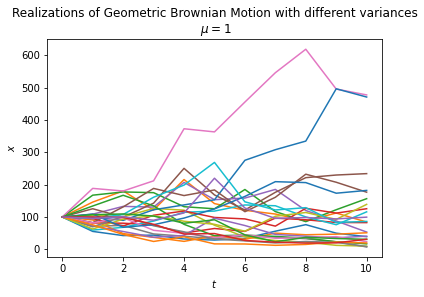

In [6]:
import matplotlib.pyplot as plt

x = tf.transpose(sample_geom_bm(25, 10))
plt.plot(100*x)
#plt.legend(np.round(sigma, 2))
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title(
    "Realizations of Geometric Brownian Motion with different variances\n $\mu=1$"
)
plt.show()


What is necessary for observation and action state:

- Price of underlying
- How many stocks are held
- How many stocks do we want to buy 
- Config of the option 

In [9]:
import numpy as np
import tf_agents
import tf_agents.environments as tfae
from tf_agents.specs import array_spec
from tf_agents.trajectories import time_step as ts


class HedgeCallEnv(tfae.py_environment.PyEnvironment):

  def __init__(self, S, K, r, sigma, T, t, init_pos_size):
    self._action_spec = array_spec.ArraySpec(
        shape=(), dtype=np.float32, name="action")

    # S, K, r, sigma, T, t, current position of stocks
    self._observation_spec = array_spec.ArraySpec(
        shape=(7,), dtype=np.float32, name="observation")
    self._state = np.array(
        [S, K, r, sigma, T, t, init_pos_size], 
        dtype="float32")

    self.S = S
    self.K = K
    self.r = r
    self.sigma= sigma
    self.T = T
    self.t = t
    self.init_pos_size = init_pos_size

    self._episode_ended = False

  def action_spec(self):
    return self._action_spec

  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._state = np.array(
        [self.S, self.K, self.r, self.sigma, self.T, self.t, self.init_pos_size], 
        dtype=np.float32)
    self._episode_ended = False
    return ts.restart(self._state)

  def _step(self, action):

    state_vec = self._state

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    # Update position in underlying
    state_vec[-1] += action
    
    # Update price of underlying
    state_vec[0] *= tf.exp(sample_log_diff_geom_bm(
        n=1, 
        length=1, 
        S=state_vec[0], 
        mu=0., 
        sigma=state_vec[3], 
        dt=0.1)).numpy()
    
    # Update time
    state_vec[5] += 0.1

    if state_vec[4] <= state_vec[5]:
      value_call = tf.maximum(0, state_vec[0] - state_vec[1])

      # In order for the episode not going on forever.
      self._episode_ended = True
    else:
      value_call = compute_bs_price(
          S=state_vec[0],
          K=state_vec[1],
          r=state_vec[2],
          sigma=state_vec[3],
          T=state_vec[4],
          t=state_vec[5])
      
    value_stock_position = state_vec[0]*state_vec[-1]

    # reward = negative hedge error = Value position in share - value of option
    reward = -tf.abs(value_stock_position - value_call).numpy()

    self._state = state_vec

    if self._episode_ended:
      return ts.termination(self._state, reward=reward)
    else:
      return ts.transition(self._state, reward=reward)


Speed comparison between Python environment and wrapped environment

In [ ]:
# Wrap the python environment
env = HedgeCallEnv(
    S=100., K=100., r=0.01, sigma=1., T=10., t=0.0, init_pos_size=0.0)
tf_env = tfae.tf_py_environment.TFPyEnvironment(env)

In [ ]:
%%time
env = HedgeCallEnv(
    S=100., K=100., r=0.01, sigma=1., T=10., t=0.0, init_pos_size=0.0)
tf_env = tfae.tf_py_environment.TFPyEnvironment(env)
tf_env.reset()

reward_lst = []

# Random action
for i in range(10000):
  action = np.random.normal(scale=2., size=(1,))
  transition = tf_env.step(action)
  
  reward_lst.append(transition.reward)

  if i%1000 == 0:
    print("round: ", i)
#    print("reward: ", transition.reward)
#    print("state: ", transition.observation)

print("Mean reward random strategy:", np.mean(reward_lst))

round:  0
round:  1000
round:  2000
round:  3000
round:  4000
round:  5000
round:  6000
round:  7000
round:  8000
round:  9000
Mean reward random strategy: -383.54446
CPU times: user 32.1 s, sys: 950 ms, total: 33.1 s
Wall time: 32.8 s


In [ ]:
%%time
env = HedgeCallEnv(
    S=100., K=100., r=0.01, sigma=1., T=10., t=0.0, init_pos_size=0.0)
env.reset()

reward_lst = []

# Random action
for i in range(10000):
  action = np.random.normal(scale=2., size=(1,))
  transition = env.step(action)
  
  reward_lst.append(transition.reward)

  if i%1000 == 0:
    print("round: ", i)
#    print("reward: ", transition.reward)
#    print("state: ", transition.observation)

print("Mean reward random strategy:", np.mean(reward_lst))

round:  0
round:  1000
round:  2000
round:  3000
round:  4000
round:  5000
round:  6000
round:  7000
round:  8000
round:  9000
Mean reward random strategy: -1142.4358
CPU times: user 28 s, sys: 923 ms, total: 29 s
Wall time: 28.6 s


In [14]:

from tf_agents.bandits.policies import policy_utilities
from tf_agents.bandits.specs import utils as bandit_spec_utils
from tf_agents.distributions import masked
from tf_agents.policies import tf_policy
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import policy_step
from tf_agents.trajectories import time_step as ts
from tf_agents.typing import types
from tf_agents.utils import nest_utils

class DeltaHedgePolicy(tf_policy.TFPolicy):

  def __init__(self, 
               time_step_spec: ts.TimeStep,
               action_spec: types.NestedTensorSpec, 
               *args, 
               **kwargs):
    observation_and_action_constraint_splitter = (
        kwargs.get('observation_and_action_constraint_splitter', None))
    self._accepts_per_arm_features = (
        kwargs.pop('accepts_per_arm_features', False))

    if observation_and_action_constraint_splitter is not None:
      if not isinstance(action_spec, tensor_spec.BoundedTensorSpec):
        raise NotImplementedError(
            'DeltaHedgePolicy only supports action constraints for '
            'BoundedTensorSpec action specs.')

      action_spec = cast(tensor_spec.BoundedTensorSpec, action_spec)
      scalar_shape = action_spec.shape.rank == 0
      single_dim_shape = (
          action_spec.shape.rank == 1 and action_spec.shape.dims == [1])

      if not scalar_shape and not single_dim_shape:
        raise NotImplementedError(
            'DeltaHedgePolicy only supports action constraints for action specs '
            'shaped as () or (1,) or their equivalent list forms.')

    super(DeltaHedgePolicy, self).__init__(
        time_step_spec, 
        action_spec, 
        *args,
        **kwargs)

  def _variables(self):
    return []

  def _action(self, time_step, policy_state, seed):
    observation_and_action_constraint_splitter = (
        self.observation_and_action_constraint_splitter)

    outer_dims = nest_utils.get_outer_shape(time_step, self._time_step_spec)
    if observation_and_action_constraint_splitter is not None:
      observation, mask = observation_and_action_constraint_splitter(
          time_step.observation)

      action_spec = cast(tensor_spec.BoundedTensorSpec, self.action_spec)
      zero_logits = tf.cast(tf.zeros_like(mask), tf.float32)
      masked_categorical = masked.MaskedCategorical(zero_logits, mask)
      action_ = tf.cast(masked_categorical.sample() + action_spec.minimum,
                        action_spec.dtype)

      # If the action spec says each action should be shaped (1,), add another
      # dimension so the final shape is (B, 1) rather than (B,).
      if action_spec.shape.rank == 1:
        action_ = tf.expand_dims(action_, axis=-1)
      policy_info = tensor_spec.sample_spec_nest(
          self._info_spec, outer_dims=outer_dims)
    else:
      observation = time_step.observation
      action_spec = cast(tensor_spec.BoundedTensorSpec, self.action_spec)

      if self._accepts_per_arm_features:
        max_num_arms = action_spec.maximum - action_spec.minimum + 1
        batch_size = tf.shape(time_step.step_type)[0]
        num_actions = observation.get(
            bandit_spec_utils.NUM_ACTIONS_FEATURE_KEY,
            tf.ones(shape=(batch_size,), dtype=tf.int32) * max_num_arms)
        mask = tf.sequence_mask(num_actions, max_num_arms)
        zero_logits = tf.cast(tf.zeros_like(mask), tf.float32)
        masked_categorical = masked.MaskedCategorical(zero_logits, mask)
        action_ = tf.nest.map_structure(
            lambda t: tf.cast(masked_categorical.sample() + t.minimum, t.dtype),
            action_spec)
      else:
        action_ = tensor_spec.sample_spec_nest(
            self._action_spec, seed=seed, outer_dims=outer_dims)

      policy_info = tensor_spec.sample_spec_nest(
          self._info_spec, outer_dims=outer_dims)

    # Update policy info with chosen arm features.
    if self._accepts_per_arm_features:
      def _gather_fn(t):
        return tf.gather(params=t, indices=action_, batch_dims=1)
      chosen_arm_features = tf.nest.map_structure(
          _gather_fn, observation[bandit_spec_utils.PER_ARM_FEATURE_KEY])

      if policy_utilities.has_chosen_arm_features(self._info_spec):
        policy_info = policy_info._replace(
            chosen_arm_features=chosen_arm_features)

    # TODO(b/78181147): Investigate why this control dependency is required.
    if time_step is not None:
      with tf.control_dependencies(tf.nest.flatten(time_step)):
        action_ = tf.nest.map_structure(tf.identity, action_)

    if self.emit_log_probability:
      if (self._accepts_per_arm_features
          or observation_and_action_constraint_splitter is not None):
        action_spec = cast(tensor_spec.BoundedTensorSpec, self.action_spec)
        log_probability = masked_categorical.log_prob(
            action_ - action_spec.minimum)
      else:
        log_probability = tf.nest.map_structure(
            lambda s: _calculate_log_probability(outer_dims, s),
            self._action_spec)
      policy_info = policy_step.set_log_probability(policy_info,
                                                    log_probability)

    step = policy_step.PolicyStep(action_, policy_state, policy_info)
    return step

  def _distribution(self, time_step, policy_state):
    raise NotImplementedError(
        'RandomTFPolicy does not support distributions yet.')
    
class DeltaHedgePolicy(tf_policy.TFPolicy):
    
    def __init__(self, 
                time_step_spec: ts.TimeStep,
                action_spec: types.NestedTensorSpec, 
                *args, 
                **kwargs):
      super(DeltaHedgePolicy, self).__init__(
        time_step_spec, 
        action_spec, 
        *args,
        **kwargs)

    def _variables(self):
      return []

    def _action(self, time_step, policy_state, seed):

      needed_short_stock = -compute_delta(
          S=time_step.observation[0],
          K=time_step.observation[1],
          r=time_step.observation[2],
          sigma=time_step.observation[3],
          T=time_step.observation[4],
          t=time_step.observation[5])
  
      action = needed_short_stock - time_step.observation[6]

      return action

    def _distribution(self, time_step, policy_state):
      raise NotImplementedError(
          "DeltaHedgePolicy does not support distributions yet.")

In [ ]:

environment = HedgeCallEnv(
    S=100., K=100., r=0.01, sigma=1., T=10., t=0.0, init_pos_size=0.0)
tfae.utils.validate_py_environment(environment, episodes=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in float_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in float_scalars


In [ ]:
#def delta_action()
#compute_delta(S, K, r, sigma, T, t)
environment = HedgeCallEnv(
    S=100., K=100., r=0.01, sigma=1., T=10., t=0.0, init_pos_size=0.0)
environment.reset()

reward_lst = []

# Random action
for i in range(10000):
  action = np.random.normal(scale=2., size=(1,))
  transition = environment.step(action)
  
  reward_lst.append(transition.reward)

  if i%1000 == 0:
    print("round: ", i)
#    print("reward: ", transition.reward)
#    print("state: ", transition.observation)

print("Mean reward random strategy:", np.mean(reward_lst))

Mean reward random strategy: -549.7078


In [ ]:
from tf_agents.policies.tf_policy import TFPolicy
from tf_agents.policies.random_py_policy import RandomPyPolicy

env =  HedgeCallEnv(
    S=100., K=100., r=0.01, sigma=1., T=10., t=0.0, init_pos_size=0.0)
policy = RandomPyPolicy(env.time_step_spec(), env.action_spec())
# Or policy = agent.policy or agent.collect_policy

policy_state = policy.get_initial_state(env.batch_size)
time_step = env.reset()

while not time_step.is_last():
  policy_step = policy.action(time_step, policy_state)
  time_step = env.step(policy_step.action)

  policy_state = policy_step.state

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in float_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: overflow encountered in float_scalars


In [15]:
env =  HedgeCallEnv(
    S=100., K=100., r=0.01, sigma=1., T=10., t=0.0, init_pos_size=0.0)
policy = DeltaHedgePolicy(env.time_step_spec(), env.action_spec())
# Or policy = agent.policy or agent.collect_policy

policy_state = policy.get_initial_state(env.batch_size)
time_step = env.reset()

while not time_step.is_last():
  policy_step = policy.action(time_step, policy_state)
  time_step = env.step(policy_step.action)

  policy_state = policy_step.state

AttributeError: ignored

In [16]:
time_step.action

AttributeError: ignored

In [13]:
policy.action(time_step, policy_state)

AttributeError: ignored

In [ ]:
environment = HedgeCallEnv(
    S=100., K=100., r=0.01, sigma=1., T=10., t=0.0, init_pos_size=0.0)
environment.reset()

bs_delta_reward_lst = []

# delta hedging action
for i in range(10000):
  needed_short_stock = -compute_delta(
          S=transition.observation[0],
          K=transition.observation[1],
          r=transition.observation[2],
          sigma=transition.observation[3],
          T=transition.observation[4],
          t=transition.observation[5])
  
  action = needed_short_stock - transition.observation[6]

  transition = environment.step(action)
  
  bs_delta_reward_lst.append(transition.reward)

  if i%1000 == 0:
    print("round: ", i)

print("Mean reward bs-delta-hedging strategy:", np.mean(bs_delta_reward_lst))

round:  0
round:  1000
round:  2000
round:  3000
round:  4000
round:  5000
round:  6000
round:  7000
round:  8000
round:  9000
Mean reward bs-delta-hedging strategy: -103.80101
